Creating a custom dataloader

In [2]:
import pandas as pd
import csv

text_file = '/kaggle/input/dataset/captions.txt'
with open(text_file, 'r') as input_file:
    # Read all lines from the input file
    lines = input_file.readlines()

# Open the output file for writing
with open('/kaggle/working/output_file', 'w') as output_file:
    # Write all lines except the first line to the output file
    output_file.writelines(lines[1:])
txt_file = '/kaggle/working/output_file'



In [3]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import pandas as pd

# Define the Flick8kDataset class
class Flick8kDataset(Dataset):
    def __init__(self, root_dir, caption_file, transform=None):
        self.root_dir = root_dir
        self.caption_file = caption_file
        self.transform = transform
        
        # Load captions
        with open(caption_file, 'r') as f:
            self.captions = f.readlines()
       
        
    def __len__(self):
        return len(self.captions)
    
    def __getitem__(self, index):
        
       
        img_id = self.captions[index].strip().split(',')[0]
        caption = self.captions[index].strip().split(',')[1]
        
        img_path = os.path.join(self.root_dir, img_id)
        # Load image
        image = Image.open(img_path).convert('RGB')
        
        # Apply transforms if provided
        if self.transform is not None:
            image = self.transform(image)
        
        return image, caption



In [5]:
# Define the transforms for image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Set the root directory and caption file path
root_dir = '/kaggle/input/dataset/Images'
caption_file = '/kaggle/working/output_file'

# Create an instance of the Flick8kDataset
dataset = Flick8kDataset(root_dir, caption_file, transform=transform)

# Create a DataLoader
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)



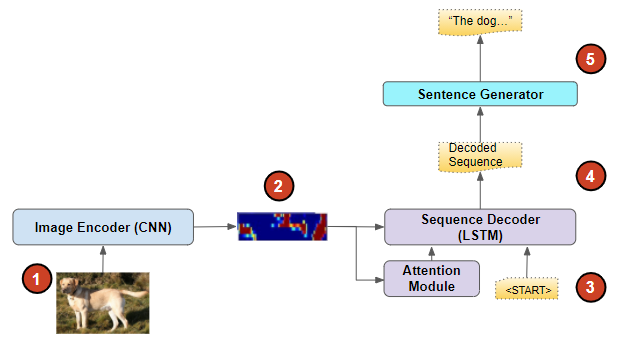

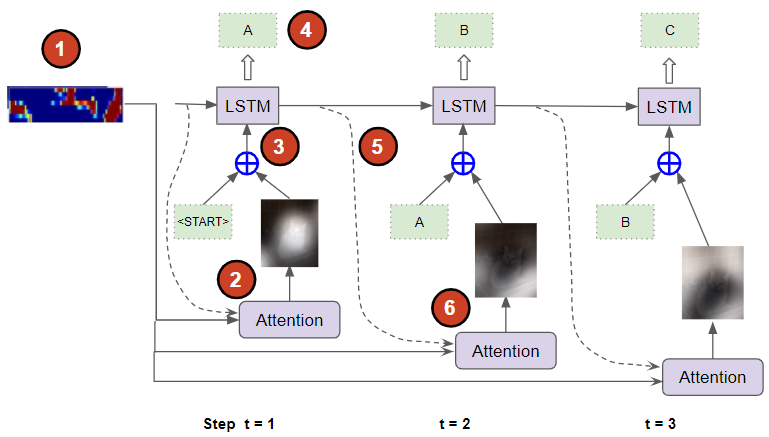

In [6]:
import torch
import torch.nn as nn
import torchvision.models as models
#uses a pre-trained ResNet-50 model to extract image features. 
#The image features are then passed through a linear layer and batch normalization to obtain 
#the encoded features.
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        self.resnet_pretrained = models.resnet50(pretrained=True)
        # exclude the last module of the ResNet-50 model, 
        # which is the fully connected layer responsible for classification
        self.modules = list(self.resnet_pretrained.children())[:-1]
        # construct a new model that consists of all 
        # the modules of the ResNet-50 model except the last one.
        self.resnet = nn.Sequential(*self.modules)
        #self.resnet.fc.in_features represents the number of input features 
        #that are orgianlly passed to the fully connected layer in ResNet-50 model.
        #basically its the size of the freature map
        #we obtain a feature representation of the image with embed_size dimensions.
        #importance of linear layer
        #This linear layer acts as a bottleneck layer, reducing the dimensionality 
        #of the extracted image features to embed_size.
        #It helps in compressing the image features into a lower-dimensional representation 
        #that can be easily handled by the subsequent layers.
        self.linear = nn.Linear(self.resnet_pretrained.fc.in_features, embed_size)
        #layer normalizes the features, providing better stability and faster convergence during training.
        #The batch normalization layer helps in reducing internal covariate shift, 
        #making the model more robust to changes in input distributions.
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

    def forward(self, images):
        #we can utilize these learned features without modifying them therefore torch.no_grad()
        #and focus on training the remaining parts of the model, 
        #such as the linear layer and batch normalization layer, to adapt to image captioning task.
        with torch.no_grad():
            features = self.resnet(images)
        print("features.shape",features.shape)
        features = features.reshape(features.size(0), -1)# flatten the feature tensor.
        print("flattened features.shape",features.shape)
        features = self.bn(self.linear(features))
        return features

In [7]:
class Attention(nn.Module):
    def __init__(self, encoder_size, decoder_size, attention_size):
        super(Attention, self).__init__()
        #encoded image features and the hidden state of the decoder LSTM.
        #The attention mechanism consists of three linear layers: encoder_att, decoder_att, and full_att.
        #The attention weights are computed using a combination of encoder and decoder hidden states.
        #The attention weights are then applied to the encoder features to obtain the attention-weighted encoding.
        #he attention weights and attention-weighted encoding are returned as outputs.
        self.encoder_att = nn.Linear(encoder_size, attention_size)
        self.decoder_att = nn.Linear(decoder_size, attention_size)
        self.full_att = nn.Linear(attention_size, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, encoder_out, decoder_hidden):
        encoder_att = self.encoder_att(encoder_out)  # (batch_size, num_pixels, attention_size)
        decoder_att = self.decoder_att(decoder_hidden)  # (batch_size, attention_size)
        att = self.full_att(self.relu(encoder_att + decoder_att.unsqueeze(1))).squeeze(2)  # (batch_size, num_pixels)
        alpha = self.softmax(att)  # (batch_size, num_pixels)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # (batch_size, encoder_size)
        return attention_weighted_encoding, alpha

In [22]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1,attention_size=512):
        super(DecoderRNN, self).__init__()
        #The embedding layer is used to convert word indices into dense word embeddings.
        # Each word in the vocabulary is represented by a dense vector of fixed size, 
        #which captures the semantic information and relationships between words. 
        #These word embeddings encode the meaning of the words in a continuous and lower-dimensional space, making it easier for the model to learn and generalize.
        # vocab_size: The number of unique words in the vocabulary. It determines the size of the vocabulary and the number of unique word indices that the embedding layer can handle.
        # embed_size: The dimensionality of the word embeddings. It specifies the size of the dense vector representation for each word.
        self.embed = nn.Embedding(vocab_size, embed_size)
        #The LSTM layer takes the word embeddings as input and processes them sequentially to capture 
        #the temporal dependencies in the captions.
        #It takes embed_size as the input size (dimensionality of the word embeddings), 
        #hidden_size as the size of the hidden state, 
        #num_layers as the number of LSTM layers, and 
        #batch_first=True to indicate that the input and output tensors have the batch dimension as the first dimension.
        #output from lstm is hidden_vector[ summarizes the LSTM's understanding of the sequence up to a particular time step]  shape (num_layers, batch_size, hidden_size)
        #and cell maintains the memory and information flow across different time steps.
#         self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)

#         The input to the LSTMCell at each time step consists of the concatenation of the current word 
#         embedding (embeddings[:, t, :]) and the attention-weighted encoding of 
#         the image features (attention_weighted_encoding). The size of this concatenated input 
#         is embed_size + hidden_size, where embed_size represents the dimensionality of the word 
#         embeddings and hidden_size represents the size of the LSTM hidden state.
        self.lstm = nn.LSTMCell(embed_size + hidden_size, hidden_size)
    #LSTMCell processes one time step at a time, and the hidden state (h) and cell state (c) are updated accordingly.
        self.attention = Attention(hidden_size, hidden_size, attention_size)
        
        # used to map the hidden states of the LSTM to the vocabulary size, enabling the generation of the next word in the caption.
        self.linear = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions):
        batch_size = features.size(0)
        num_pixels = features.size(1)
        hidden_size = self.lstm.hidden_size

        embeddings = self.embed(torch.LongTensor(captions))  # (batch_size, seq_length, embed_size)

        h, c = self.init_hidden_state(features)  # initialize the hidden state

        predictions = []
        alphas = []

        for t in range(embeddings.size(1)):
            attention_weighted_encoding, alpha = self.attention(features, h)
            #The current word embedding (embeddings[:, t, :]) and the attention-weighted encoding are concatenated along the feature dimension (dim=1) to create the input for the LSTM cell at the current time step.
            lstm_input = torch.cat((embeddings[:, t, :], attention_weighted_encoding), dim=1)
            #The LSTM cell takes the concatenated input (lstm_input) and the previous hidden state (h) and cell state (c) as inputs. It computes the new hidden state (h) and cell state (c) for the current time step.
            h, c = self.lstm(lstm_input, (h, c))
            #The hidden state (h) obtained from the LSTM cell is passed through a linear layer (self.linear) to predict the scores over the vocabulary. This gives the output predictions for the current time step.
            preds = self.linear(h)
            predictions.append(preds)
            alphas.append(alpha)
        #predictions is a tensor containing the predicted scores over the vocabulary for each word in the caption sequence
        predictions = torch.stack(predictions, dim=1)  # (batch_size, seq_length, vocab_size)
        alphas = torch.stack(alphas, dim=1)  # (batch_size, seq_length, num_pixels)

        return predictions, alphas
        #image features
        #caption sequences- word indices
        #line passes the caption sequences, excluding the last word, through the embedding layer.
#         embeddings = self.embed(captions)#(batch_size, sequence_length, embed_size).
#         #It adds the image features as the initial input to the LSTM, allowing the model to condition the caption generation on the provided image.
#         #(features.unsqueeze(1)->(batch_size, 1, feature_size)
#         embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)#(batch_size, sequence_length + 1, embed_size).
#         hiddens, _ = self.lstm(embeddings)
#         outputs = self.linear(hiddens)
#         return outputs
    
    
        

In [23]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1,attention_size=512):
        super(ImageCaptioningModel, self).__init__()
        self.encoder = EncoderCNN(embed_size)
        self.decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers,attention_size)

    def forward(self, images, captions):
        features = self.encoder(images)
        predictions, alphas = self.decoder(features, captions)
        return predictions, alphas

In [10]:
import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

# Assuming you have a list of captions called 'captions'
tokenizer = get_tokenizer('basic_english')
all_captions = []
for _, captions in dataloader:
    for caption in captions:
        tokenized_captions = tokenizer(caption)#['a', 'girls', 'is', 'jumping', 'in', 'the', 'sand', '.']
        all_captions.append(tokenized_captions)
        

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [11]:
# Build the vocabulary
vocabulary = build_vocab_from_iterator(all_captions,specials=['<SOS>', '<EOS>'])
print(vocabulary)
# Convert tokens to numerical indices
numerical_captions = []
for caption in all_captions:
    numerical_caption = [vocabulary[token] for token in caption]
    numerical_captions.append(torch.tensor(numerical_caption))

# Print the vocabulary size
vocab_size = len(vocabulary)
print("Vocabulary size:", vocab_size)

Vocab()
Vocabulary size: 8713


In [24]:
# Example usage
embed_size = 256
hidden_size = 512
num_layers = 2
num_epochs = 10
attention_size = 512

model = ImageCaptioningModel(embed_size, hidden_size, vocab_size, num_layers,attention_size)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
for epoch in range(num_epochs):
    for images, captions in dataloader:
        images = images.to(device)
        captions = captions
        
        # Add SOS and EOS tokens to each caption
        tokenized_captions = [tokenizer(caption) for caption in captions]
        tokenized_captions = [['<SOS>'] + tokens + ['<EOS>'] for tokens in tokenized_captions]
#         print( tokenized_captions)
#         [['<SOS>', 'this', 'brown', 'and', 'white', 'dog', 'is', 'chasing', 'a', 'soccer', 
#           'ball', '.', '<EOS>'], ['<SOS>', 'a', 'woman', 'climbing', 'a', 'rock',
#                                   'cliff', '.', '<EOS>']],
        numerical_captions = []
        for caption in tokenized_captions:
            numerical_caption = [vocabulary[token] for token in caption]
            numerical_captions.append(torch.tensor(numerical_caption).unsqueeze(0))
#         print(numerical_captions)
#         [tensor([[  0, 321,  27,   8,  14,   9,   7, 267,   2, 102,  40,   3,   1]]), 
#          tensor([[  0,   2,  18, 115,   2,  82, 252,   3,   1]]), 
#          tensor([[  0,  47,  61,  17,  39,   4,   2, 114, 302,   3,   1]]),
#          tensor([[  0,   2, 258, 124,   2, 198, 179, 121, 217,  57,  24,   3,   1]])]
        max_caption_length = max(caption.size(1) for caption in numerical_captions)
        print(max_caption_length)
        # Pad the captions to a fixed length
        padded_captions = []
        for caption in numerical_captions:
#             print(caption.shape)
            padding_length = max_caption_length - caption.size(1)
#             print(padding_length)
#             print(torch.zeros(padding_length).unsqueeze(0).shape)
            padded_caption = torch.cat([caption ,torch.zeros(padding_length).unsqueeze(0)],dim=1)
#             print( padded_caption.shape)
            padded_captions.append(padded_caption)

        # Concatenate and transfer captions to device
        captions = torch.stack(padded_captions, dim=0).to(device)
        print(captions.shape)
        predictions, alphas = model.forward(images, captions[:, :-1])
        targets = captions[:, 1:]  # Exclude the start word from targets
        loss = criterion(predictions.reshape(-1, vocab_size), targets.reshape(-1))

        # Backward pass
        loss.backward()

        # Update the model parameters
        optimizer.step()

        # Print the loss
        if (i+1) % log_step == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_steps}], Loss: {loss.item()}")

    # Save the model checkpoint
    if (epoch+1) % save_step == 0:
        torch.save(model.state_dict(), f"image_captioning_model_epoch_{epoch+1}.pth")

        # Compute the loss
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
